#   **Drowsiness Detection using Transfer Learning**

**Importing necessary libraries**

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras 
from tensorflow.keras import layers  # type: ignore
from tensorflow.keras.preprocessing import image # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

**Load an closed eye image in grayscale mode and display it**

(224, 224)

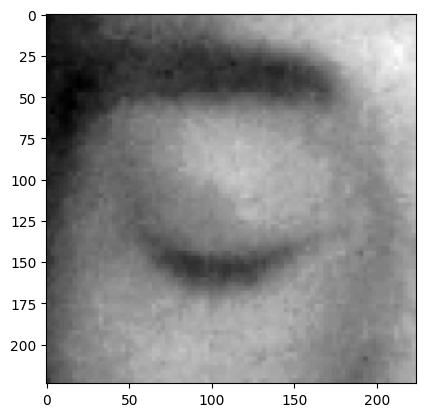

In [2]:
# Reading an image using OpenCV in grayscale mode (cv2.IMREAD_GRAYSCALE)
img_array = cv2.imread(r"data\train\Close\s0001_00015_0_0_0_0_0_01.png", cv2.IMREAD_GRAYSCALE)
# Display the loaded image using Matplotlib with a grayscale color map
plt.imshow(img_array, cmap="gray")
# Output the shape of the image array (height, width)
img_array.shape

**Load an open eye image in grayscale mode and display it**

(224, 224)

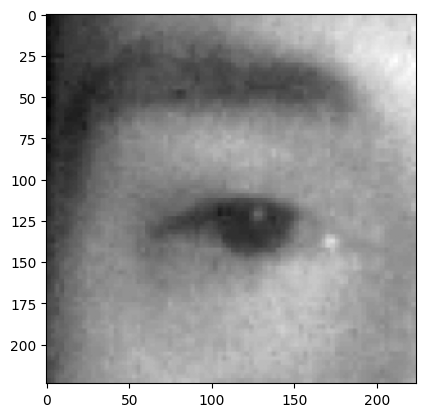

In [3]:
# Reading an image using OpenCV in grayscale mode (cv2.IMREAD_GRAYSCALE)
img_array = cv2.imread(r"data\test\Open\s0001_01984_0_0_1_0_0_01.png", cv2.IMREAD_GRAYSCALE)
# Display the loaded image using Matplotlib with a grayscale color map
plt.imshow(img_array, cmap="gray")
# Output the shape of the image array (height, width)
img_array.shape


**Set the directory for the training images and define class categories**

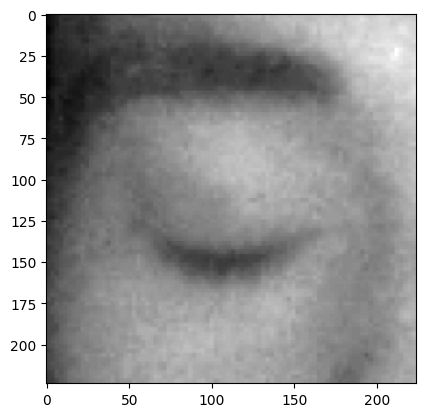

In [4]:
Datadirectory = "data/train/"  # Path to the training data folder
Classes = ["Close", "Open"]  # List of class categories (folders)

# Loop through each class/category (Close, Open)
for category in Classes:
    path = os.path.join(Datadirectory, category)
    
    # Loop through all the images in the current class folder
    for img in os.listdir(path):
        # Read the image in grayscale mode
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        # Convert the grayscale image to RGB for display (Matplotlib expects RGB)
        backtorgb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
        
        plt.imshow(img_array, cmap="gray")
        plt.show()  # Show the image
        break
    break 

**Define the target image size for resizing**

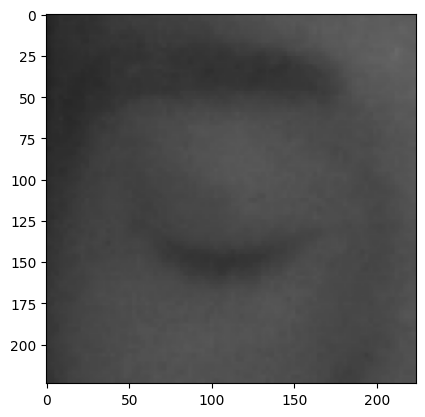

In [5]:
img_size = 224  # Set the desired size to 224x224 pixels
# Resize the image to the target size (224x224) using OpenCV
new_array = cv2.resize(backtorgb, (img_size, img_size))
plt.imshow(new_array, cmap='gray') 
plt.show()  

**Define data augmentation and preprocessing for training and validation/test sets**


In [6]:
# Define paths for training, testing, and validation data directories
train = "data/train"  
test = "data/test"    

# Define ImageDataGenerator with augmentation for training
datagen = ImageDataGenerator(
    rescale=1./255,        # Normalize pixel values from range (0, 255) to (0, 1)
    rotation_range=20,     # Randomly rotate images in the range of 20 degrees
    width_shift_range=0.2, # Randomly shift images horizontally by up to 20%
    height_shift_range=0.2, # Randomly shift images vertically by up to 20%
    shear_range=0.2,       # Apply random shear transformation
    zoom_range=0.2,        # Randomly zoom in on images
    horizontal_flip=True,  # Randomly flip images horizontally
    validation_split=0.2   # Reserve 20% of the data for validation
)

# Training set (80% of data)
train_generator = datagen.flow_from_directory(
    train,  # Training data directory
    target_size=(224, 224),  # Resize all images to 224x224
    batch_size=32,           # Process images in batches of 32
    class_mode='binary',     # Use binary class mode (for binary classification tasks)
    subset='training'        # Use the 'training' subset (80% of data)
)

# Validation set (20% of data)
val_generator = datagen.flow_from_directory(
    train,  # Training data directory, validation is taken from this
    target_size=(224, 224),  # Resize all images to 224x224
    batch_size=32,           # Process images in batches of 32
    class_mode='binary',     # Use binary class mode (for binary classification tasks)
    subset='validation'      # Use the 'validation' subset (20% of data)
)

# Test set (Separate folder, no data augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale the test images

test_generator = test_datagen.flow_from_directory(
    test,  # Test data directory
    target_size=(224, 224),  # Resize all test images to 224x224
    batch_size=32,           # Process images in batches of 32
    class_mode='binary',     # Use binary class mode (for binary classification tasks)
    shuffle=False            # Don't shuffle test data during evaluation
)


Found 26214 images belonging to 2 classes.
Found 6552 images belonging to 2 classes.
Found 6000 images belonging to 2 classes.


**Define the base model using MobileNet with ImageNet weights, excluding the top (classification) layer**


In [7]:
# Load pre-trained MobileNet model without the top layers (i.e., without classification layers)
model = tf.keras.applications.mobilenet.MobileNet()

In [8]:
# Extract the input and output layers from the base model
base_input = model.layers[1].input  # The input layer of the pre-trained model
base_output = model.layers[-4].output  # The output layer before the top classification layers

# Add a Flatten layer to convert the 2D output into a 1D vector
Flat_layer = layers.Flatten()(base_output)

# Add a Dense layer with a single unit for binary classification (sigmoid activation for binary output)
final_output = layers.Dense(1)(Flat_layer)

# Apply sigmoid activation to the output for binary classification (0 or 1)
final_output = layers.Activation('sigmoid')(final_output)

# Create the new model with the input from the base model and the custom output
new_model = keras.Model(inputs=base_input, outputs=final_output)

# Print the summary of the new model
new_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,229,889 (12.32 MB)

 Trainable params: 3,208,001 (12.24 MB)

 Non-trainable params: 21,888 (85.50 KB)

**Compile the new model with binary cross-entropy loss, Adam optimizer, and accuracy metric**

In [9]:
new_model.compile(
    loss="binary_crossentropy",  # Binary cross-entropy loss for binary classification
    optimizer="adam",            # Adam optimizer for efficient training
    metrics=["accuracy"]         # Track accuracy during training and evaluation
)

**Train the model and store history**

In [10]:
# Train the model and store the training history
history = new_model.fit(
    train_generator,              # The training data generator
    validation_data=val_generator,  # The validation data generator
    epochs=5                      # Number of epochs to train the model
)

c:\Users\dixit\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
820/820 ━━━━━━━━━━━━━━━━━━━━ 1374s 2s/step - accuracy: 0.9726 - loss: 0.0902 - val_accuracy: 0.9338 - val_loss: 0.1491
Epoch 2/5
820/820 ━━━━━━━━━━━━━━━━━━━━ 1354s 2s/step - accuracy: 0.9922 - loss: 0.0246 - val_accuracy: 0.9715 - val_loss: 0.1139
Epoch 3/5
820/820 ━━━━━━━━━━━━━━━━━━━━ 1361s 2s/step - accuracy: 0.9927 - loss: 0.0243 - val_accuracy: 0.9731 - val_loss: 0.0688
Epoch 4/5
820/820 ━━━━━━━━━━━━━━━━━━━━ 1513s 2s/step - accuracy: 0.9924 - loss: 0.0216 - val_accuracy: 0.9118 - val_loss: 0.1990
Epoch 5/5
820/820 ━━━━━━━━━━━━━━━━━━━━ 1556s 2s/step - accuracy: 0.9930 - loss: 0.0208 - val_accuracy: 0.9147 - val_loss: 0.1757


**Save the trained model to a file in the H5 format**

In [11]:
new_model.save("drowsiness_detection_model.h5")
print("Model saved as 'drowsiness_detection_model.h5'")

Model saved as 'drowsiness_detection_model.h5'


**Evaluate the model's performance on the test set**

In [12]:
# Evaluate the model on the test data and print the accuracy
test_loss, test_acc = new_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")


188/188 ━━━━━━━━━━━━━━━━━━━━ 63s 334ms/step - accuracy: 0.9782 - loss: 0.0603
Test Accuracy: 0.9450


**Plot training and validation loss and accuracy over all epochs**


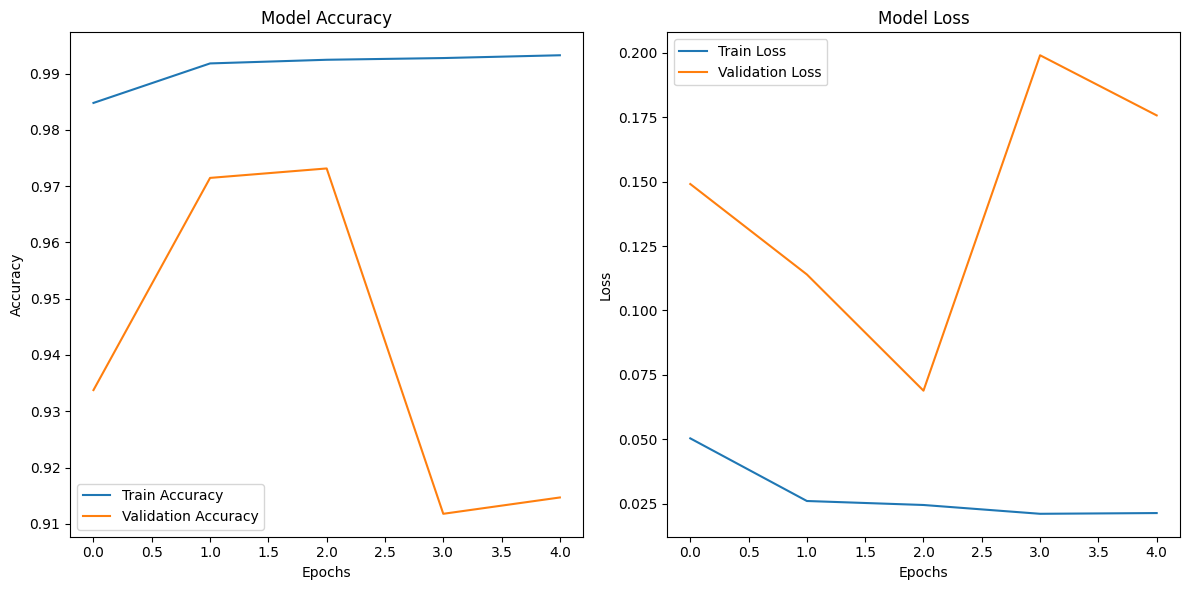

In [13]:
# Plotting Accuracy and Loss graphs for each epoch
plt.figure(figsize=(12, 6))

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

##    Manually prediction on images

In [14]:
# Function to make a prediction on any image
model = tf.keras.models.load_model("drowsiness_detection_model.h5")
def predict_image(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match model input
    img_array /= 255.0  # Normalize
    
    prediction = model.predict(img_array)
    print(f"Predicted Class: {prediction}")


##      Close Eyes

In [15]:
image_path = r"data\test\Close\s0001_00071_0_0_0_0_0_01.png"  # Change this to an actual image path
predict_image(image_path, new_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step
Predicted Class: [[1.2193606e-05]]


In [16]:
image_path = r"data\test\Close\s0001_00349_0_0_0_0_1_01.png"  # Change this to an actual image path
predict_image(image_path, new_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted Class: [[9.580879e-06]]


In [17]:
image_path = r"data\test\Close\s0037_04684_1_1_0_2_0_01.png"  # Change this to an actual image path
predict_image(image_path, new_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predicted Class: [[0.04965938]]


In [18]:
image_path = r"data\test\Close\s0001_00610_0_0_0_0_0_01.png"  # Change this to an actual image path
predict_image(image_path, new_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predicted Class: [[9.030404e-06]]


In [19]:
image_path = r"data\test\Close\s0001_01043_0_1_0_0_0_01.png"  # Change this to an actual image path
predict_image(image_path, new_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted Class: [[0.00043451]]


##  Open Eyes

In [20]:
image_path = r"data\test\Open\s0001_02266_0_0_1_0_0_01.png"  # Change this to an actual image path
predict_image(image_path, new_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Predicted Class: [[0.883411]]


In [21]:
image_path = r"data\test\Open\s0001_01975_0_0_1_0_0_01.png"  # Change this to an actual image path
predict_image(image_path, new_model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Predicted Class: [[0.70779526]]


In [22]:
image_path = r"data\test\Open\s0001_02718_0_1_1_2_0_01.png"  # Change this to an actual image path
predict_image(image_path, new_model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Predicted Class: [[0.8694868]]


In [23]:
image_path = r"data\test\Open\s0003_00568_0_0_1_0_0_01.png"  # Change this to an actual image path
predict_image(image_path, new_model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Predicted Class: [[0.09607869]]
